# Analysis of kinesin walking

(c) 2017 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](kinesin_walking.ipynb).*

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In this notebook, we will use some streetfighting hacking to solve an interesting problem in physical biology involving probability. We examine data from [Yildiz, et al., *Science*, 2004](http://rpdata.caltech.edu/courses/course_papers/protected/yildiz_selvin_2004.pdf). They performed single molecule measurements of kinesin processing along an immobilized microtubule on a coverslip. One of the kinesin heads was labeled with a fluorescent dye, and the authors measured the waiting times for the dye to move. Two mechanisms of walking (which we discussed in class) can be discerned by investigating whether one or two random events (detachments of a head) need to arrive for the labeled head to move.

Our task here is to assess the waiting times between steps and determine whether they are more commensurate with the waiting time for one unbinding event or two successive ones.

### Histogram of waiting times

First, we will use the `np.loadtxt()` function to load the data into a Numpy array. We use the `skiplines=1` keyword argument so we skip the header row in the data set.

In [2]:
# The waiting times for steps
t = np.loadtxt('yildiz_step_times.csv', skiprows=1)

How should we plot these data? One option is a histogram, as we have already encountered.

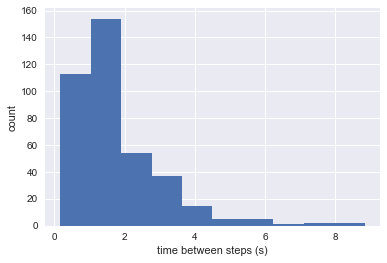

In [3]:
# Plot a histogram of the data
_ = plt.hist(t)

# Label the axes
plt.xlabel('time between steps (s)')
plt.ylabel('count');

At first glance, this does not quite look like an exponential distribution because there appears to be a peak. It is still kind of hard to tell. We could rather try more bins, perhaps using the square root rule, where the number of bins is given by the square root of the number of observations.

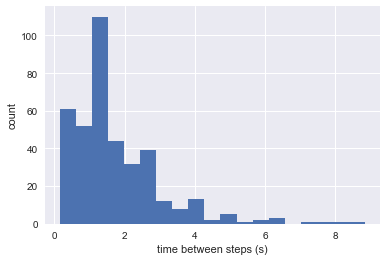

In [4]:
# Plot a histogram of the data
_ = plt.hist(t, bins=int(np.sqrt(len(t))))

# Label the axes
plt.xlabel('time between steps (s)')
plt.ylabel('count');

### The empirical cumulative distribution function (ECDF)

The histograms can give different results depending on the number of bins. This presents a **binning bias**. But we do not need to have a binning bias. We can instead plot the empirical cumulative distribution function (ECDF), $\hat{F}(t)$. The ECDF is defined as

\begin{align}
\hat{F}(t) = \text{fraction of observed waiting times ≤ t}.
\end{align}

How can we compute and plot that? You can convince yourself that the following will give the x and y values of a plot.

1. The x-values consist of the sorted array of the $n$ measurements.
2. The y-values go from $1/n$ to 1 in a total of $n$ steps.

We can write a function to compute these to conveniently plot the ECDF.

In [5]:
def ecdf(data):
    """Compute x and y values for plotting ECDF"""
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    
    return x, y

Ok, now let's plot the ECDF of the observed waiting times.

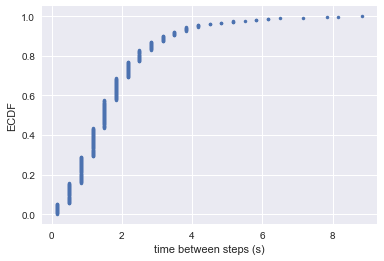

In [6]:
# Compute x and y values for plotting ECDF
x, y = ecdf(t)

# Plot result using dots as markers
plt.plot(x, y, '.')
plt.xlabel('time between steps (s)')
plt.ylabel('ECDF');

Ah, now we see some structure in the data. First, we see a digitization of the measured time between steps, which can be due to the rate at which images were acquired in the experiment. We can also more clearly see the bend in the tail of the distribution, which is contrary to the CDF of the exponential distribution.

### Comparing to the exponential distribution

To see how closely the observed times follow the Exponential distribution, we can compare it to the CDF of the Exponential distribution. We worked out in class that its CDF is

\begin{align}
F(t;\tau) = 1 - \mathrm{e}^{-t/\tau}.
\end{align}

We also reasoned in class that the best estimate for $\tau$ is the mean of the waiting times. So, let's plot this curve on top of the CDF.

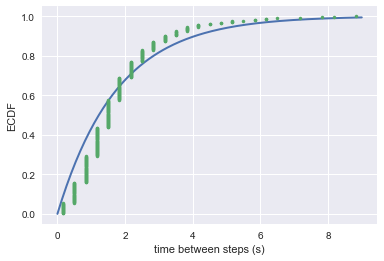

In [7]:
# Best estimate for tau
tau = np.mean(t)

# x-values for plotting the CDF
t_cdf = np.linspace(0, 9, 200)

# y-values for CDF
cdf_exp = 1 - np.exp(-t_cdf/tau)

# Plot the theoretical Exponential CDF
plt.plot(t_cdf, cdf_exp, linewidth=2)

# Plot the ECDF on top
plt.plot(x, y, '.')
plt.xlabel('time between steps (s)')
plt.ylabel('ECDF');

We do see a systematic difference between the observed data and the theoretical CDF. But is the model where there are two detachment events before observing the head move any better? What is its CDF?

### Hacking our way to the two-step CDF

I happen to know the story of the Gamma distribution, and I know that it matches our problem.

> The amount of time to wait for $k$ successive Poisson processes to arrive is Gamma distributed.

But let's say we don't know that. We can still streetfight our way to the CDF by *simulating* the waiting time for steps.

To do that, we remember that the waiting time for a detachment event is completely independent of the previous waiting time. So, we just have to wait for two Poisson processes to arrive. The time it takes for one process to arrive is Exponentially distributed, as is the time for the second. So, we can **sample** out of the distribution for waiting times for two processes by generating two Exponentially distributed random numbers and adding them.

But how do we draw Exponentially distributed numbers? Earlier in the bootcamp, you used the `np.random.rand()` function to draw Uniformly distributed random numbers on the interval between zero and one. The `np.random` module has other functions to generate randon numbers, including `np.random.exponential()`, which generates exponentially distributed numbers!

Importantly, it takes a positional argument, which is the value of the parameter $\tau$. Additionally, we can specify the `size` keyword argument to tell `np.random.exponential()` how many random numbers to draw. So, let's draw two sets of Exponentially distributed random numbers and add them!

But, wait a minute. What value should we choose for $\tau$? Remember that for an Exponential distribution, the best estimate for $\tau$ is the mean observed waiting time. But here, we have two detachment events, each with the same time constant. It makes sense, then, that the time constant for a single step should be half of the mean observed waiting time.

Ok. **Now** we are ready to draw our random numbers. We will draw 100,000 so we can get a nice, smooth CDF.

In [8]:
# Time for first step
t1 = np.random.exponential(tau/2, size=100000)

# Time for the second step
t2 = np.random.exponential(tau/2, size=100000)

# Total time
t_two_step = t1 + t2

Excellent. Now, to get the "CDF," we just plot the ECDF of our random samples. We will construct a plot with the ECDF, and the CDFs of the Exponential and the theoretical distribution we just sampled out of.

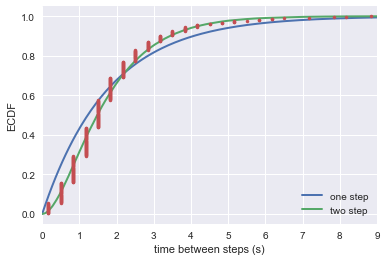

In [9]:
# Plot the theoretical Exponential CDF
plt.plot(t_cdf, cdf_exp, linewidth=2, label='one step')

# Compute ECDF for two-step model
x_two_step, y_two_step = ecdf(t_two_step)

# Plot the two-step model ECDF
plt.plot(x_two_step, y_two_step, linewidth=2, label='two step')

# Plot the ECDF on top
plt.plot(x, y, '.')
plt.xlabel('time between steps (s)')
plt.ylabel('ECDF')
plt.legend(loc='lower right')
plt.xlim(0, 9);

The two-step model matches the data much more closely. It seems, then, that it is superior to the one-step model. This was one part of the puzzle on how Yildiz and coworkers verified that kinesin walks hand over hand.

### Appendix: Hacking versus knowing the story

I mentioned that I knew the story of the Gamma distribution. Just to show you that hacker stats can get you really far, I will plot the theoretical CDF along with the one we generated using hacker streetfighting.

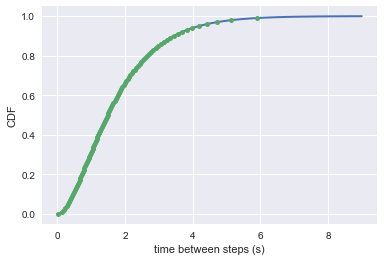

In [10]:
# Compute theoretical CDF for Gamma distribution with k = 2 and tau->t/2
tau_gamma = tau / 2
cdf_gamma = 1 - (1 + t_cdf/tau_gamma) * np.exp(-t_cdf / tau_gamma)

# Plot theoretical CDF
plt.plot(t_cdf, cdf_gamma, linewidth=2)

# Plot hacker stats CDF, with every 1000th point for clarity
plt.plot(x_two_step[::1000], y_two_step[::1000], '.', markersize=10)
plt.xlabel('time between steps (s)')
plt.ylabel('CDF');

Perfect! It's nice to know your distributions, but you can always simulate them.